Problem Description

This activity guides you through the process of performing cluster analysis on a dataset using k-means. In this activity, we will perform cluster analysis on the minute-weather.csv dataset using the k-means algorithm. Recall that this dataset contains weather measurements such as temperature, relative humidity, etc., from a weather station in San Diego, California, collected at one-minute intervals. The goal of cluster analysis on this data is to identify different weather patterns for this weather station.

Learning Objectives

By the end of this activity, you will be able to:

Scale all features so that each feature is zero-normalized
Create an "elbow" plot, the number of clusters vs. within-cluster sum-of-squared errors, to determine a value for k, the number of clusters in k-means
Perform cluster analysis on a dataset using k-means
Create parallel coordinates plots to analyze cluster centers
In this activity, you will be programming in a Jupyter Python Notebook. If you have not already started the Jupyter Notebook server, see the instructions in the Reading Instructions for Starting Jupyter.

Step 1. Open Jupyter Python Notebook. Open a web browser by clicking on the web browser icon at the top of the toolbar:


Navigate to localhost:8889/tree/Downloads/big-data-4:


Open the clustering notebook by clicking on clustering.ipynb:


Step 2. Load minute weather data. Execute the first cell to load the classes used in this activity:

In [1]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from notebooks import utils
%matplotlib inline

/home/cloudera/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/cloudera/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Execute the second cell to load the minute weather data in minute_weather.csv:



In [2]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:///home/cloudera/Downloads/big-data-4/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

Step 3. Subset and remove unused data. Let's count the number of rows in the DataFrame:




In [3]:
df.count()

1587257

There are over 1.5 million rows in the DataFrame. Clustering this data on your computer in the Cloudera VM can take a long time, so let's only one-tenth of the data. We can subset by calling filter() and using the rowID column:



In [4]:
df.columns

['rowID',
 'hpwren_timestamp',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'rain_accumulation',
 'rain_duration',
 'relative_humidity']

In [6]:
filterDF = df.filter((df.rowID%10) == 0)
filterDF.count()

158726

Let's compute the summary statistics using describe():



In [9]:
filterDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102434,3.051716552830638,905.0,929.5
air_temp,158726,61.851589153636304,11.833569210641757,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057623969742642,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4188016208098886,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784567,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421125052424393,0.0,31.6


The weather measurements in this dataset were collected during a drought in San Diego. We can count the how many values of rain accumulation and duration are 0:



In [10]:
filterDF.filter(filterDF.rain_accumulation==0).count()

157812

In [11]:
filterDF.filter(filterDF.rain_duration==0).count()

157237

Since most the values for these columns are 0, let's drop them from the DataFrame to speed up our analyses. We can also drop the hpwren_timestamp column since we do not use it.

In [12]:
workingDF = filterDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

Let's drop rows with missing values and count how many rows were dropped:



In [13]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

Step 4. Scale the data. Since the features are on different scales (e.g., air pressure values are in the 900’s, while relative humidities range from 0 to 100), they need to be scaled. We will scale them so that each feature will have a value of 0 for the mean, and a value of 1 for the standard deviation.

First, we will combine the columns into a single vector column. Let's look at the columns in the DataFrame:



In [14]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

We do not want to include rowID since it is the row number. The minimum wind measurements have a high correlation to the average wind measurements, so we will not include them either. Let's create an array of the columns we want to combine, and use VectorAssembler to create the vector column:



In [15]:
featuresUsed = ['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed,outputCol='feature_unscaled')
assembled = assembler.transform(workingDF)

Next, let's use StandardScaler to scale the data:



In [17]:
scaler = StandardScaler(inputCol='feature_unscaled',outputCol='features',withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

The withMean argument specifies to center the data with the mean before scaling, and withStd specifies to scale the data to the unit standard deviation.

Step 5. Create elbow plot. The k-means algorithm requires that the value of k, the number of clusters, to be specified. To determine a good value for k, we will use the “elbow” method. This method involves applying k-means, using different values for k, and calculating the within-cluster sum-of-squared error (WSSE). Since this means applying k-means multiple times, this process can be very compute-intensive. To speed up the process, we will use only a subset of the dataset. We will take every third sample from the dataset to create this subset:

In [19]:
scaledData = scaledData.select("features","rowID")

elbowset = scaledData.filter((scaledData.rowID % 3)==0).select("features")
elbowset.persist()

DataFrame[features: vector]

The last line calls the persist() method to tell Spark to keep the data in memory (if possible), which will speed up the computations.

Let's compute the k-means clusters for k = 2 to 30 to create an elbow plot:

In [21]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset,clusters)

Training for cluster size 2 
......................WSSE = 131527.91745939464 
Training for cluster size 3 
......................WSSE = 117081.88205469701 
Training for cluster size 4 
......................WSSE = 108835.78305948559 
Training for cluster size 5 
......................WSSE = 101858.71560209486 
Training for cluster size 6 
......................WSSE = 96467.70188126095 
Training for cluster size 7 
......................WSSE = 93130.73499701456 
Training for cluster size 8 
......................WSSE = 90821.11563205693 
Training for cluster size 9 
......................WSSE = 86536.6029832607 
Training for cluster size 10 
......................WSSE = 84540.16172394581 
Training for cluster size 11 
......................WSSE = 82212.66933570655 
Training for cluster size 12 
......................WSSE = 79968.84304536619 
Training for cluster size 13 
......................WSSE = 78948.87453944686 
Training for cluster size 14 
......................WSSE = 79581.6031

The first line creates an array with the numbers 2 through 30, and the second line calls the elbow() function defined in the utils.py library to perform clustering. The first argument to elbow() is the dataset, and the second is the array of values for k. The elbow() function returns an array of the WSSE for each number of clusters.

Let's plot the results by calling elbow_plot() in the utils.py library:

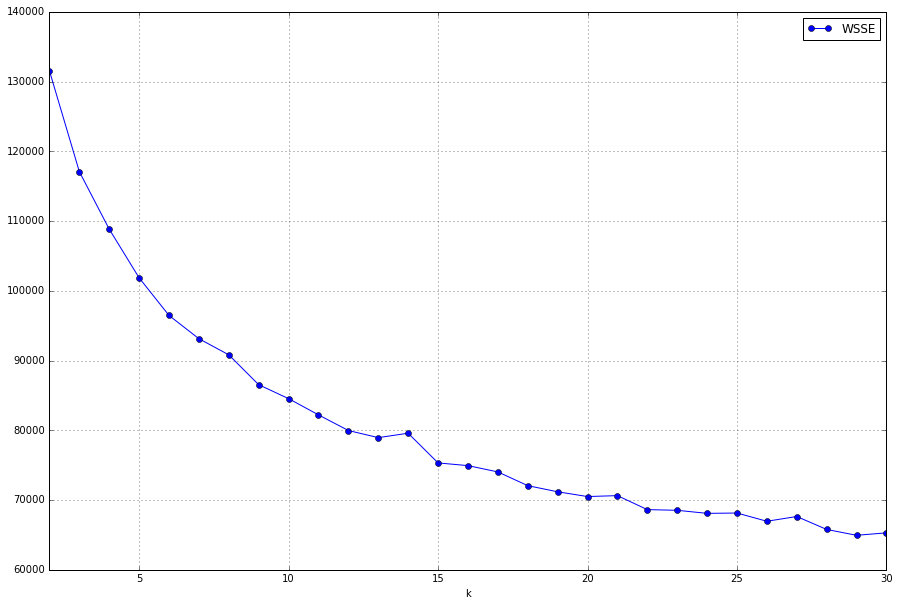

In [24]:
utils.elbow_plot(wsseList,cluster)

The values for k are plotted against the WSSE values, and the elbow, or bend in the curve, provides a good estimate for the value for k. In this plot, we see that the elbow in the curve is between 10 and 15, so let's choose k = 12. We will use this value to set the number of clusters for k-means.

Step 6. Cluster using selected k. Let's select the data we want to cluster:



In [25]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

Again, we call the persist() method to cache the data in memory for faster access.

We can perform clustering using KMeans:

In [26]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

The first line creates a new KMeans instance with 12 clusters and a specific seed value. (As in previous hands-on activities, we use a specific seed value for reproducible results.) The second line fits the data to the model, and the third applies the model to the data.

Once the model is created, we can determine the center measurement of each cluster:

In [27]:
centers = model.clusterCenters()
centers

[array([ 0.14221374,  0.76752394,  0.83500629, -0.72459999,  1.06093699,
        -0.69992358,  0.5585219 , -0.73303601, -0.68326156]),
 array([-0.22207602, -0.44690815, -0.94798633, -0.64332491, -0.79669707,
        -0.66121641, -1.14943472, -0.58587814,  0.66092794]),
 array([-0.61104376,  0.06825548,  0.44885222,  1.4997144 ,  0.53098176,
         1.40699245,  0.29604458,  1.59111517,  0.12884763]),
 array([ 0.05812915, -0.90839942,  0.62662517, -0.60008365,  0.84154935,
        -0.5768598 ,  0.37376307, -0.61448994,  1.08416898]),
 array([-0.72435231, -1.19527153,  0.36435323,  0.48145153,  0.48654093,
         0.46766615,  0.18664277,  0.46317405,  1.3512401 ]),
 array([ 0.34844518, -0.99839059,  1.85828222, -0.70085269, -1.53073443,
        -0.60836904,  1.4007507 , -0.76931721,  0.90488353]),
 array([ 0.28802336,  0.28249947, -1.52884939, -0.61134886, -1.20594529,
        -0.53743988,  1.79679699, -0.66368798, -0.36261943]),
 array([ 0.13910886,  0.83674637,  1.89580536, -0.62386

It is difficult to compare the cluster centers by just looking at these numbers. So we will use plots in the next step to visualize them.



Step 7. Create parallel plots of clusters and analysis. A parallel coordinates plot is a great way to visualize multi-dimensional data. Each line plots the centroid of a cluster, and all of the features are plotted together. Recall that the feature values were scaled to have mean = 0 and standard deviation = 1. So the values on the y-axis of these parallel coordinates plots show the number of standard deviations from the mean. For example, +1 means one standard deviation higher than the mean of all samples, and -1 means one standard deviation lower than the mean of all samples.

We'll create the plots with matplotlib using a Pandas DataFrame each row contains the cluster center coordinates and cluster label. (Matplotlib can plot Pandas DataFrames, but not Spark DataFrames.) Let's use the pd_centers() function in the utils.py library to create the Pandas DataFrame:



In [29]:
P = utils.pd_centers(featuresUsed,centers)

Let's show clusters for "Dry Days", i.e., weather samples with low relative humidity:



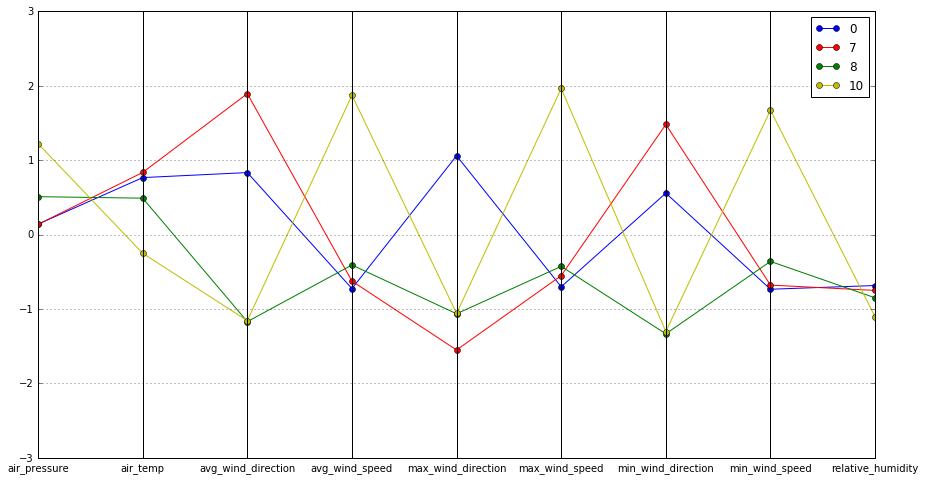

In [30]:
utils.parallel_plot(P[P['relative_humidity']< -0.5],P)

The first argument to parallel_plot selects the clusters whose relative humidities are centered less than 0.5 from the mean value. All clusters in this plot have relative_humidity < -0.5, but they differ in values for other features, meaning that there are several weather patterns that include low humidity.

Note in particular cluster 4. This cluster has samples with lower-than-average wind direction values. Recall that wind direction values are in degrees, and 0 means wind coming from the North and increasing clockwise. So samples in this cluster have wind coming from the N and NE directions, with very high wind speeds, and low relative humidity. These are characteristic weather patterns for Santa Ana conditions, which greatly increase the dangers of wildfires.

Let's show clusters for "Warm Days", i.e., weather samples with high air temperature:

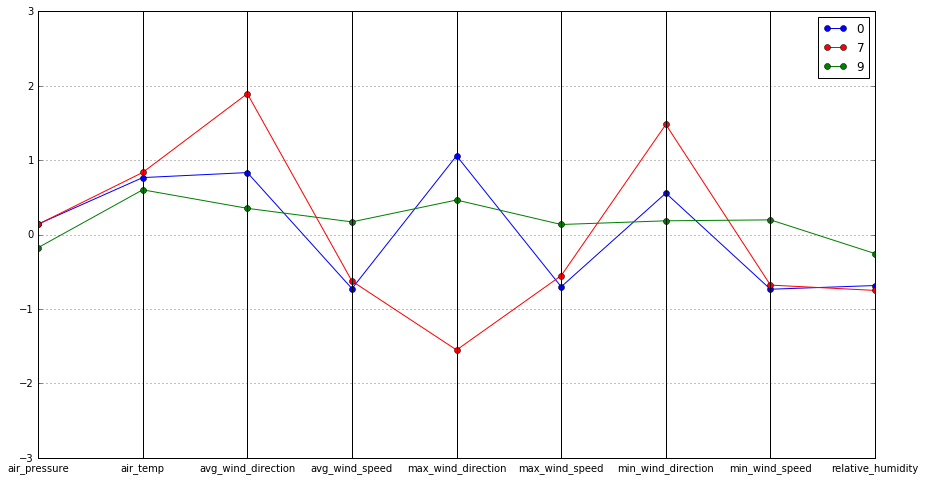

In [31]:
utils.parallel_plot(P[P['air_temp']>0.5],P)

All clusters in this plot have air_temp > 0.5, but they differ in values for other features.

Let's show clusters for "Cool Days", i.e., weather samples with high relative humidity and low air temperature:



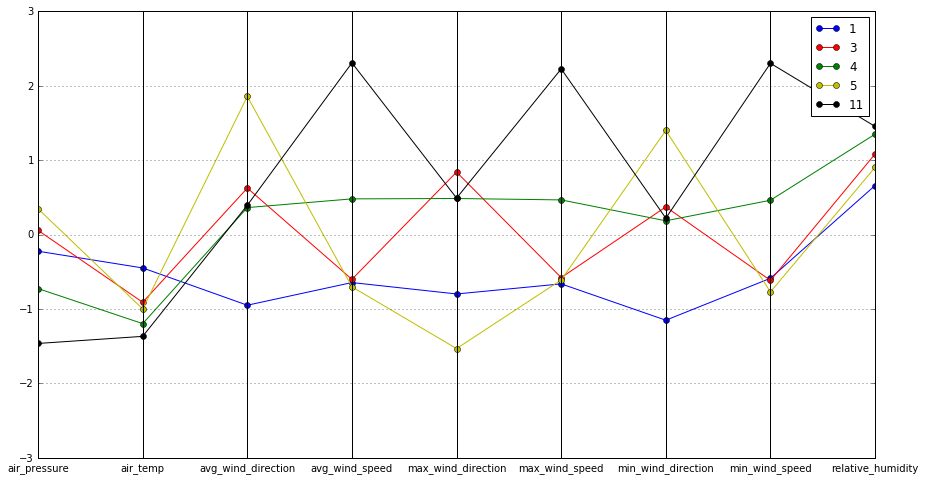

In [33]:
utils.parallel_plot(P[(P['relative_humidity']>0.5) & (P['air_temp']<0.5)],P)

All clusters in this plot have relative_humidity > 0.5 and air_temp < 0.5. These clusters represent cool temperature with high humidity and possibly rainy weather patterns. For cluster 5, note that the wind speed values are high, suggesting stormy weather patterns with rain and wind.

So far, we've seen all the clusters except 2 since it did not fall into any of the other categories. Let's plot this cluster:

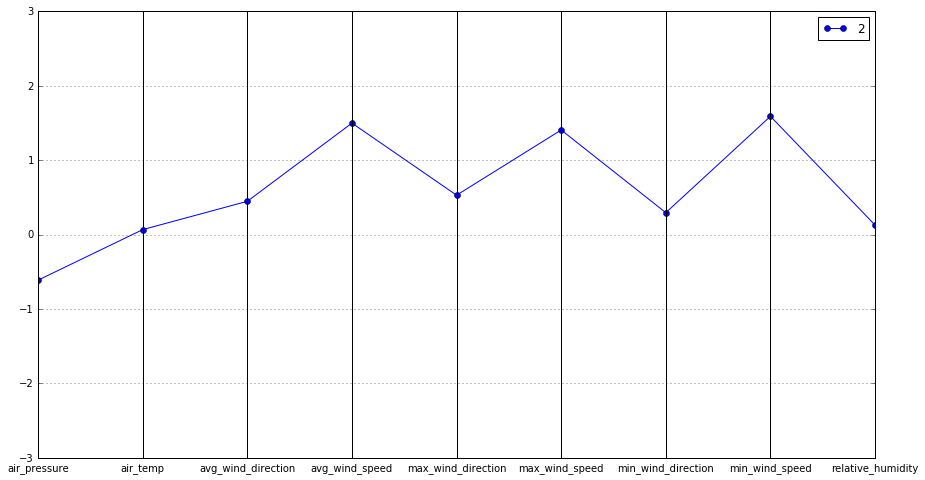

In [34]:
utils.parallel_plot(P.iloc[[2]],P)

Cluster 2 captures days with mild weather